Notebook on learning R, \gamma and p simultaneously using Environment Design

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import get_parameter_sample, bayesian_parameter_learning
from src.utils.make_environment import transition_matrix, get_candidate_environments
from src.utils.environment_design import environment_search
from src.utils.visualization import plot_posterior_distribution
from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

Create Environment

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 6, 6
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R_true = np.zeros((N, M))
R_true[-1, 0] = 0.2
R_true[-1, -1] = 1
R_true[2, -2] = -1
R_true[2, -3] = -1
R_true = R_true.flatten()

goal_states = np.where(R_true != 0)[0]
del R_true

## Prior sampling


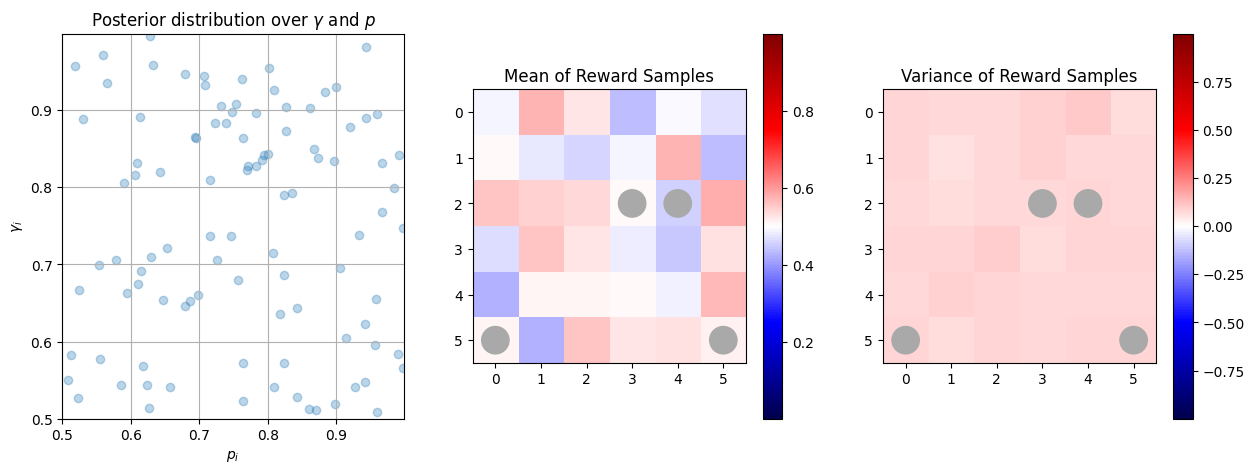

In [4]:
posterior_samples_0 = bayesian_parameter_learning(expert_trajectories=[], 
                                                  sample_size=100, 
                                                  previous_sample=None, 
                                                  goal_states=goal_states, 
                                                  n_states=n_states)

plot_posterior_distribution(posterior_samples=posterior_samples_0, N=N, M=M, absorbing_states=goal_states)

#### Start by finding an environment to generate initial trajectories from


In [28]:
#Set sample ranges for unknown parameters
p_limits = (0.9, 0.9)
gamma_limits = (0.8, 0.8)
R_limits = (0,1)

# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 5
n_posterior_samples = 25
n_traj_per_sample = 10

## 0.2 Setup the environment
N, M = 6, 6
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R = np.zeros((N, M))
R[-1, 0] = 0.1
R[-1, -1] = 0.25
# R[2, -2] = -0.1
# R[2, -3] = -0.1
R = R.flatten()

goal_states = np.where(R != 0)[0]

del R

# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_0)), size=5, replace=False
)
samples = [posterior_samples_0[i] for i in sample_idxs]

candidate_envs_likelihood = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)

envs = environment_search(N, M, "likelihood", goal_states, n_env_samples, samples, n_traj_per_sample, candidate_envs_likelihood)

Evaluating candidate environments using likelihood:   0%|          | 0/5 [00:00<?, ?it/s, highest_regret=-inf]

started gradient descent


Evaluating candidate environments using likelihood:  20%|██        | 1/5 [00:10<00:43, 10.83s/it, highest_regret=-inf]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  40%|████      | 2/5 [00:21<00:32, 10.77s/it, highest_regret=-inf]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  60%|██████    | 3/5 [00:32<00:21, 10.87s/it, highest_regret=-inf]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  80%|████████  | 4/5 [00:43<00:10, 10.80s/it, highest_regret=-inf]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood: 100%|██████████| 5/5 [00:53<00:00, 10.79s/it, highest_regret=-inf]

finished gradient descent


#### Create the unknown true agent and trajectories in the chosen environment


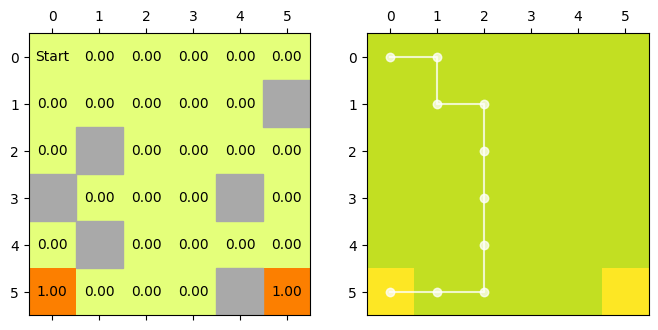

In [149]:
# Start by making the agent we want to learn the policy of
agent_p = 0.8
agent_gamma = 0.9
agent_R = np.zeros((N, M))
agent_R[-1, 0] = 1
agent_R[-1, -1] = 1


# R[2, -2] = -0.1
# R[2, -3] = -0.1
agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

###################for now generate environments randomly###########################
T_true = transition_matrix(N, M, p=0.999, absorbing_states=goal_states)

candidate_envs_likelihood = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)

envs = candidate_envs_likelihood



# Generate 2 trajectories in the env with the highest regret
env_1: Environment = envs[0]

T_agent = transition_matrix(env_1.N, env_1.M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=env_1.wall_states, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

# Generate trajectories
trajectories = generate_n_trajectories(
    env_1.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
    start_state=env_1.start_state,
    max_steps=(env_1.N + env_1.M - 2) * 2,
)

expert_trajectories = [(env_1, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_1.wall_states,
    start_state=(env_1.start_state // M, env_1.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

#### Sample from the posterior under these trajectories


In [152]:
# Sample from posterior
posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories, 5_000, previous_sample=None, goal_states = goal_states, n_states = n_states
)

# Keep the last 10_000 of samples
posterior_samples_1 = posterior_samples_1[-3000:]
# Plot the posterior distribution

Posterior sampling:   2%|▏         | 110/5000 [00:05<04:51, 16.75it/s, Acceptance rate=22.7, step_size=0.22]/tmp/ipykernel_108753/2533279894.py:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(T[s, a, next_s] * policy[s, a])


p_values:  (0.7948346406149132, 0.7004148154442935, 0.7797293405748426, 0.7982454666939235, 0.7082175245732434, 0.7723035997146754, 0.9038305972786265, 0.9650399811337071, 0.944448063346864, 0.8542062815605835, 0.8152332329191786, 0.543296026030732, 0.5154632155793922, 0.6700785560561493, 0.8118084416811592, 0.8054157034120867, 0.9770141040243239, 0.6440036470157009, 0.5740181115140247, 0.6281693766337514, 0.5935589722283509, 0.553890841573076, 0.7735901067562595, 0.925265489911555, 0.9458467347757129, 0.5524886127114252, 0.659965931051396, 0.5082586035847436, 0.528484108840259, 0.6838615855768516, 0.577795200294986, 0.6998007715264899, 0.9912243540891439, 0.8275449892728872, 0.5197798972115393, 0.5304446182582284, 0.8202039828333059, 0.5544356174937712, 0.7597613248033858, 0.8630284791760989, 0.7732284577744764, 0.7885411978488607, 0.9527957453031407, 0.9264548983904536, 0.6722001609574413, 0.6222679140983975, 0.7037936882998473, 0.7881271771730012, 0.5890684793857053, 0.5297410466112

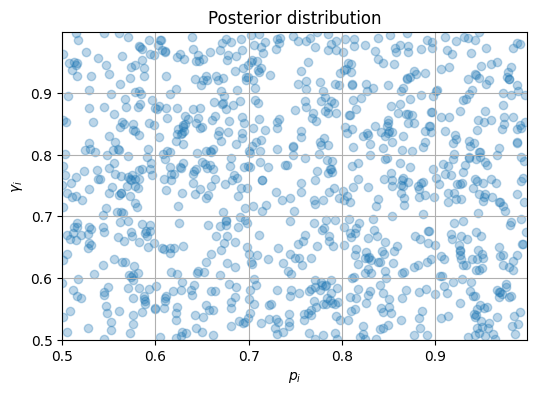

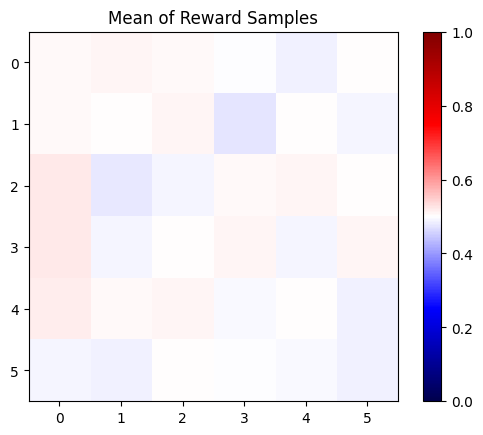

In [153]:
plot_posterior_distribution(posterior_samples_0)

p_values:  (0.9021927452924754, 0.9021927452924754, 0.9021927452924754, 0.9021927452924754, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8425000116359396, 0.8192485121679761, 0.8192485121679761, 0.8070372201807222, 0.8070372201807222, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9290778741299207, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.9046793610871682, 0.8906323386817523, 0.8906323386817523, 0.8906323386817523, 0.8906323386817523, 0.8906323386817523, 0.9534985482108161, 0.9534985482108161, 0.9405683787106384, 0.9405683787106384, 0.940568

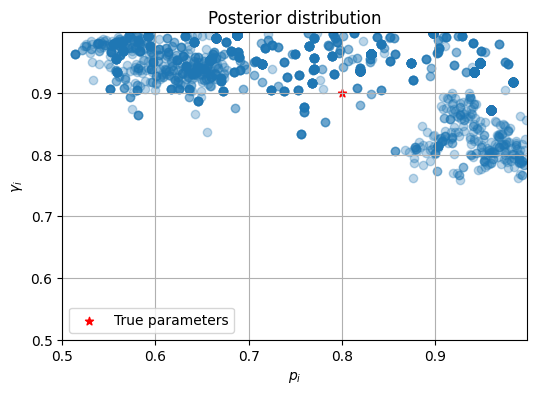

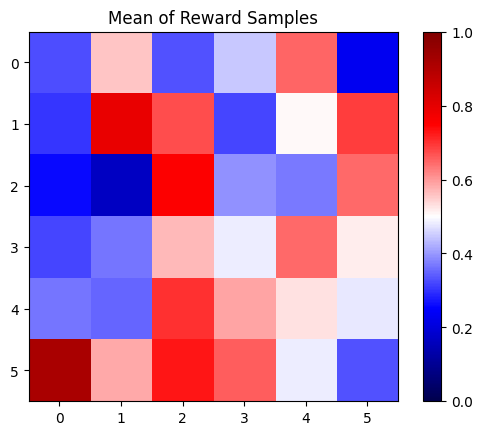

In [154]:
# plot_posterior_distribution(
#     posterior_samples_1, true_params=ParamTuple(agent_p, agent_gamma)
# )
plot_posterior_distribution(posterior_samples_1, true_params = ParamTuple(p = 0.8, gamma = 0.9, R = None))

#### Start round two, maximize regret with the new posterior


In [62]:
# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_1)), size=100, replace=False
)
samples = [posterior_samples_1[i] for i in sample_idxs]

candidate_envs_likelihood = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)

envs = environment_search(N, M, "likelihood", goal_states, n_env_samples, samples, n_traj_per_sample, candidate_envs_likelihood)

Evaluating candidate environments using likelihood:   0%|          | 0/15 [00:00<?, ?it/s, highest_regret=-inf]

started gradient descent


Evaluating candidate environments using likelihood:   7%|▋         | 1/15 [00:20<04:42, 20.19s/it, highest_regret=0.422]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  13%|█▎        | 2/15 [01:05<07:33, 34.86s/it, highest_regret=0.422]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  20%|██        | 3/15 [01:26<05:41, 28.46s/it, highest_regret=0.422]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  27%|██▋       | 4/15 [01:46<04:38, 25.32s/it, highest_regret=0.422]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  33%|███▎      | 5/15 [02:36<05:39, 33.99s/it, highest_regret=0.422]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  40%|████      | 6/15 [02:57<04:26, 29.65s/it, highest_regret=0.424]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  47%|████▋     | 7/15 [03:45<04:44, 35.60s/it, highest_regret=0.424]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  53%|█████▎    | 8/15 [04:06<03:37, 31.11s/it, highest_regret=0.424]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  60%|██████    | 9/15 [04:27<02:46, 27.79s/it, highest_regret=0.436]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  67%|██████▋   | 10/15 [05:06<02:36, 31.29s/it, highest_regret=0.436]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  73%|███████▎  | 11/15 [05:26<01:51, 27.82s/it, highest_regret=0.436]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  80%|████████  | 12/15 [05:45<01:16, 25.38s/it, highest_regret=0.436]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  87%|████████▋ | 13/15 [06:04<00:46, 23.23s/it, highest_regret=0.438]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood:  93%|█████████▎| 14/15 [06:22<00:21, 21.77s/it, highest_regret=0.438]

finished gradient descent
started gradient descent


Evaluating candidate environments using likelihood: 100%|██████████| 15/15 [07:07<00:00, 28.48s/it, highest_regret=0.438]

finished gradient descent


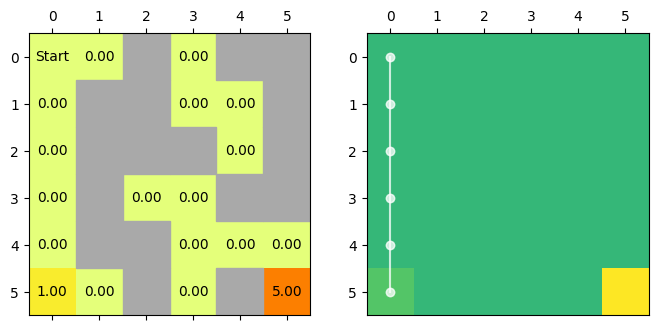

In [63]:
# Generate 2 trajectories in the env with the highest regret
env_1: Environment = envs[0]

T_agent = transition_matrix(env_1.N, env_1.M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=env_1.wall_states, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

# Generate trajectories
trajectories = generate_n_trajectories(
    env_1.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
    start_state=env_1.start_state,
    max_steps=(env_1.N + env_1.M - 2) * 2,
)

expert_trajectories.append((env_1, trajectories))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_1.wall_states,
    start_state=(env_1.start_state // M, env_1.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Posterior sampling:  34%|███▍      | 342/1000 [00:50<00:24, 26.34it/s, Acceptance rate=21.3, step_size=0.31]/tmp/ipykernel_108753/2533279894.py:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(T[s, a, next_s] * policy[s, a])


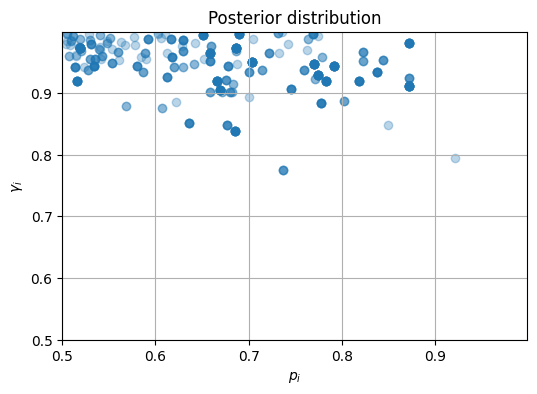

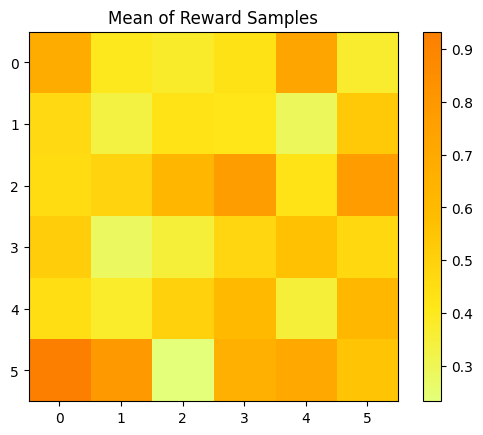

In [65]:
# Sample from posterior
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories, 1_000, previous_sample=None, goal_states = goal_states, n_states = n_states
)

# Keep the last 10_000 of samples
posterior_samples_2 = posterior_samples_2[-500:]
# Plot the posterior distribution
plot_posterior_distribution(posterior_samples_2)

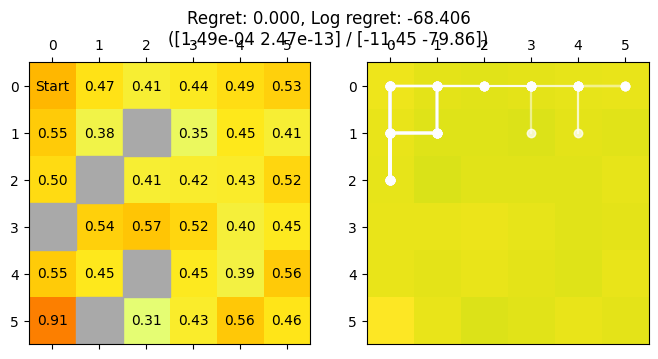

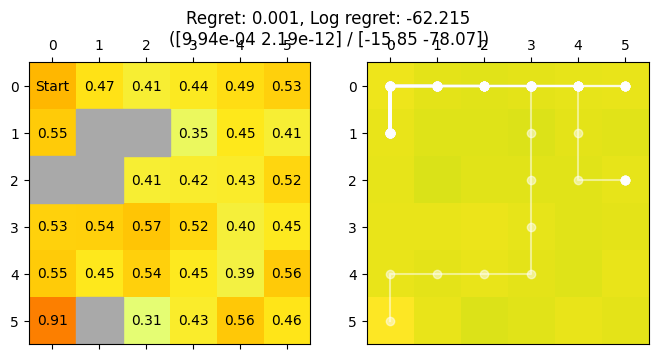

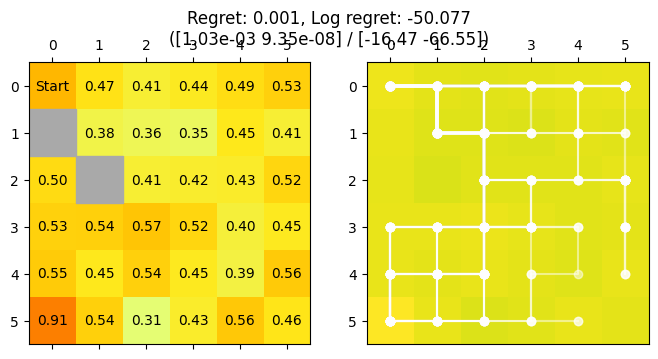

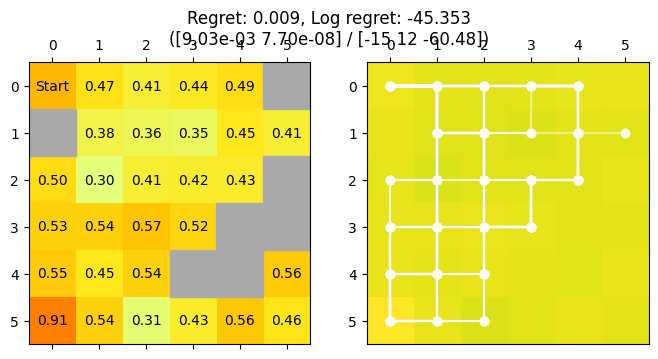

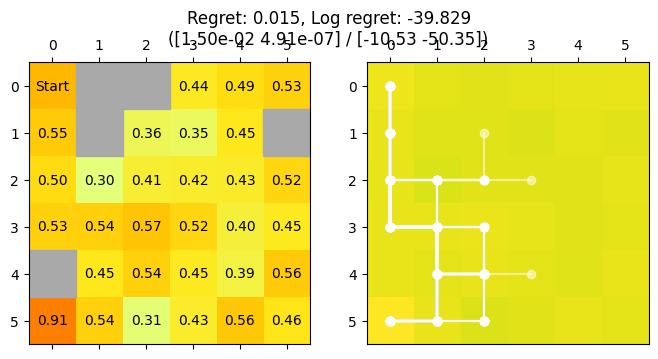

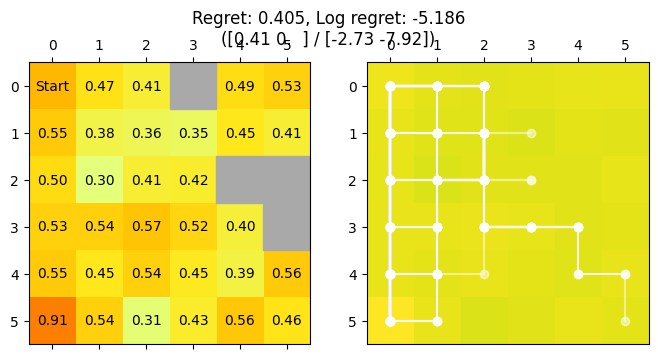

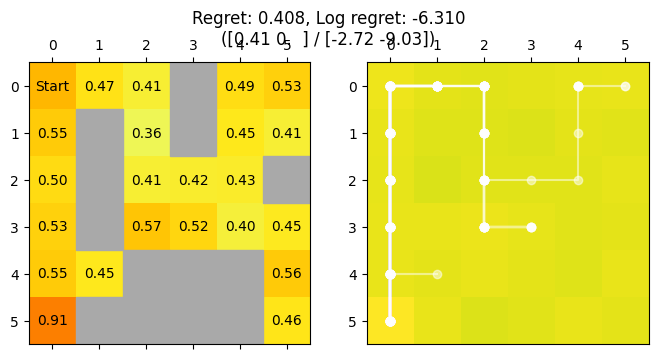

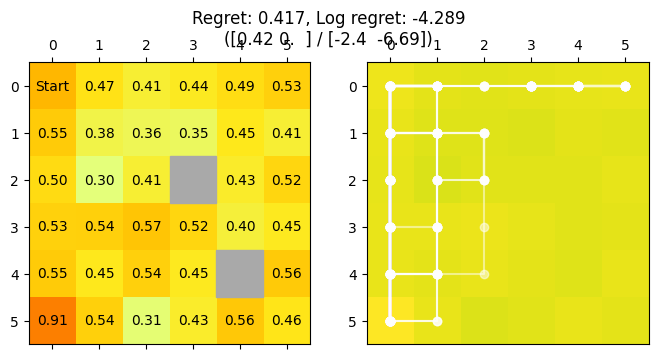

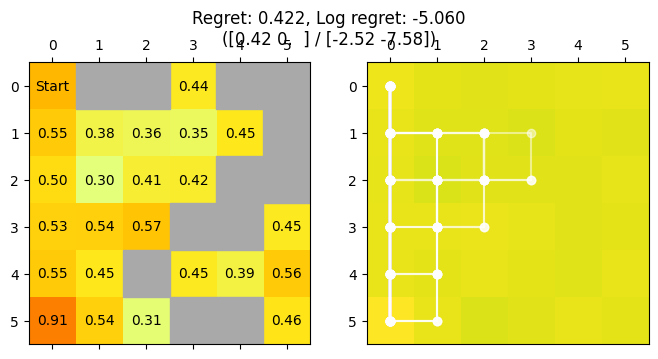

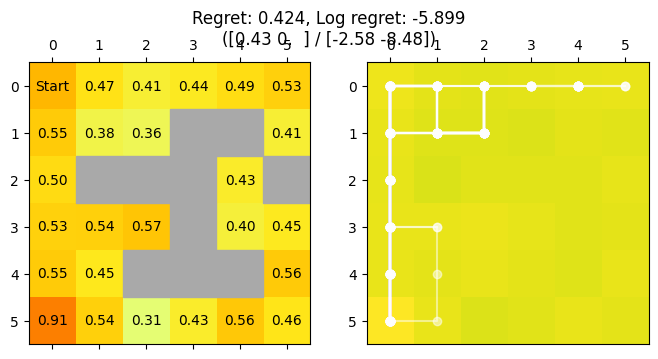

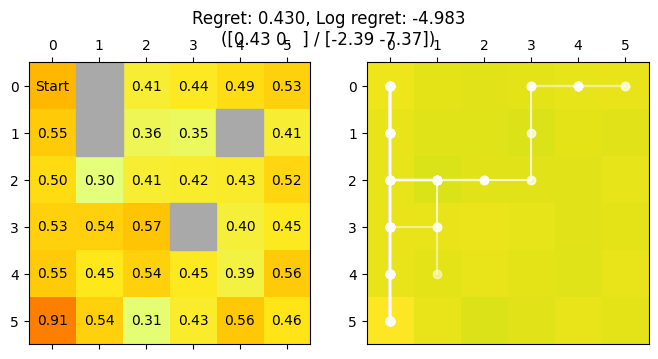

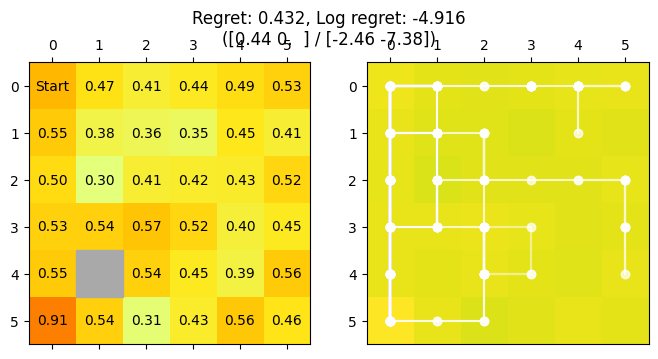

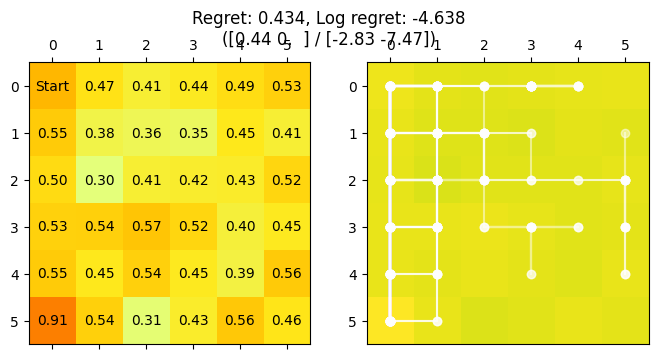

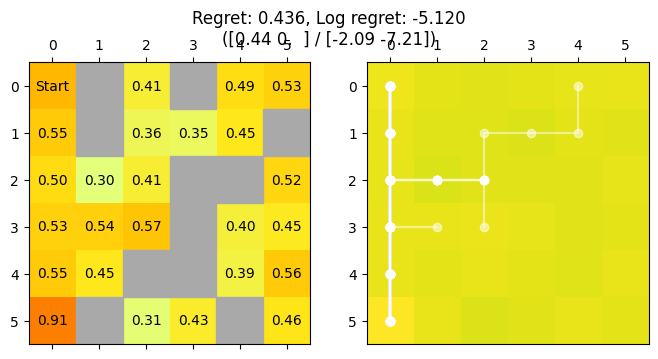

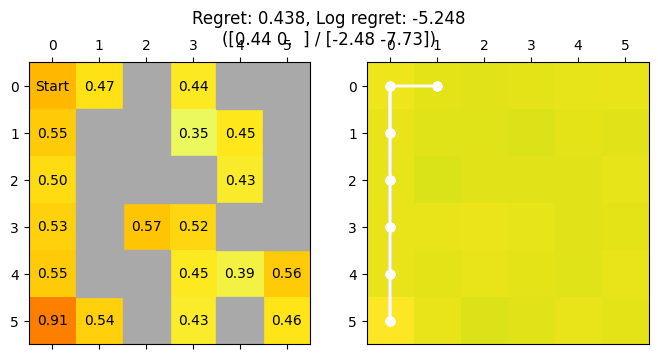

In [66]:
plot_environments_with_regret(envs)

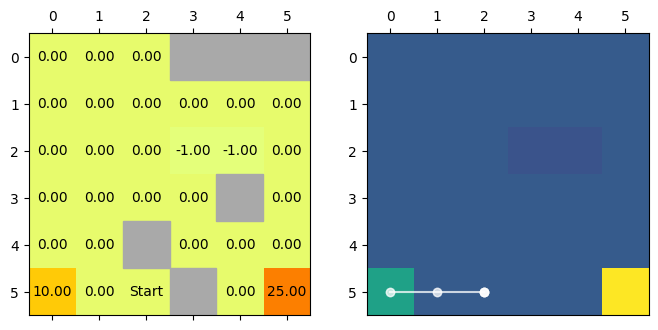

In [86]:
# Generate 2 trajectories in the env with the highest regret
env_2: Environment = envs[0]
N, M, R = env_2.N, env_2.M, env_2.R

T_agent = transition_matrix(N, M, p=agent_p, R=R)
agent_policy = soft_q_iteration(R, T_agent, gamma=agent_gamma, beta=20.0)

# Generate trajectories
absorbing_states = np.where(R != 0)[0]  # Absorbing states
trajectories_2 = generate_n_trajectories(
    env_2.T_true,
    agent_policy,
    absorbing_states,
    start_state=env_2.start_state,
    n_trajectories=2,
    max_steps=(env_2.N + env_2.M - 2) * 2,
)

# expert_trajectories.append((env_2, trajectories_2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    R.reshape(N, M),
    env_2.wall_states,
    start_state=(env_2.start_state // M, env_2.start_state % M),
    ax=ax1,
)

# Show the trajectories_2
plot_trajectories(N, M, trajectories_2, R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Insert walls manually

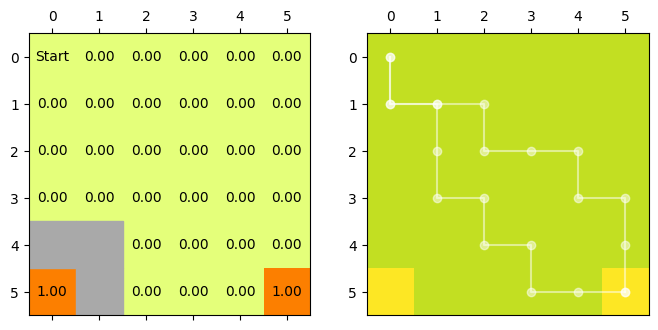

In [144]:
# Generate 2 trajectories in the env with the highest regret
env_1: Environment = envs[0]

#cut off rewards in bottom left corner
wall_states_bottom_left = [24, 25, 31]

T_agent = transition_matrix(env_1.N, env_1.M, p=agent_p, absorbing_states=goal_states)
T_true_walls_bottom_left = insert_walls_into_T(T_true, wall_indices=wall_states_bottom_left, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states_bottom_left, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)


env_walls = Environment(N, M, T_true_walls_bottom_left,wall_states_bottom_left, None, 0, len(wall_states_bottom_left))

# Generate trajectories
trajectories = generate_n_trajectories(
    env_walls.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
    start_state=env_1.start_state,
    max_steps=(env_1.N + env_1.M - 2) * 2,
)

expert_trajectories.append((env_walls, trajectories))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_walls.wall_states,
    start_state=(env_1.start_state // M, env_1.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

In [117]:
init_example = ParamTuple(p = 0.8, gamma = 0.9, R = posterior_samples_1[-1].R)

p_values:  (0.5124059256594269, 0.5124059256594269, 0.5124059256594269, 0.5124059256594269, 0.5076143928885163, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5226625237733479, 0.5208534396942508, 0.5208534396942508, 0.5208534396942508, 0.5208534396942508, 0.5208534396942508, 0.5208534396942508, 0.5208534396942508, 0.5042189308770889, 0.5042189308770889, 0.5042189308770889, 0.5042189308770889, 0.5042189308770889, 0.5042189308770889, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5127443313584232, 0.5069194168132928, 0.5069194168132928, 0.5069194168132928, 0.5069194168132928, 0.5069194168132928, 0.508722

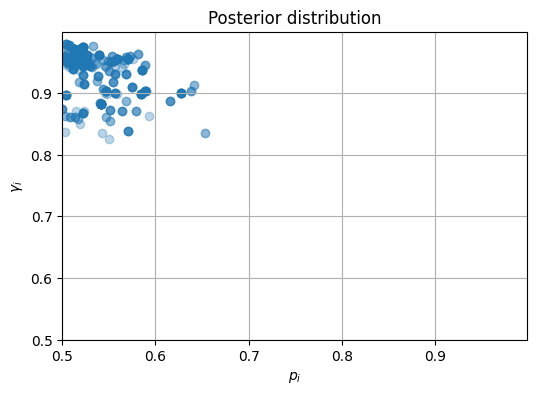

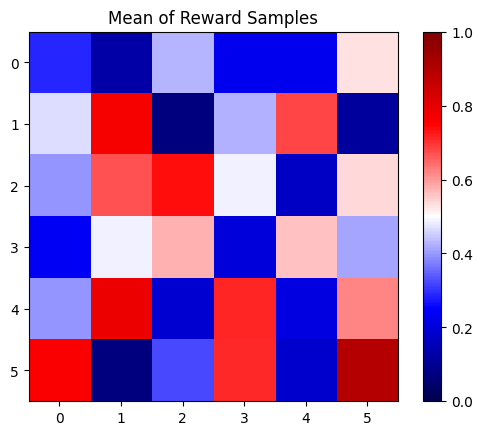

In [146]:
# Sample from posterior
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories, 1000, previous_sample=init_example, goal_states = goal_states, n_states = n_states
)

# Keep the last 10_000 of samples
posterior_samples_2 = posterior_samples_2[-500:]
# Plot the posterior distribution
plot_posterior_distribution(posterior_samples_2)

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s, Acceptance rate=100, step_size=0.12]

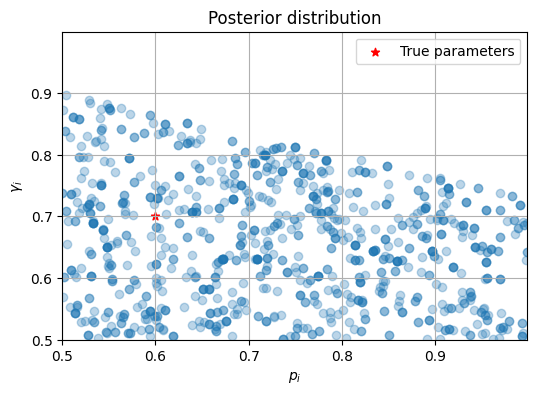

In [87]:
# Sample from posterior
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories, 1_000, previous_sample=posterior_samples_1[-1]
)

# Plot the posterior distribution
plot_posterior_distribution(posterior_samples_2, true_params=true_params)

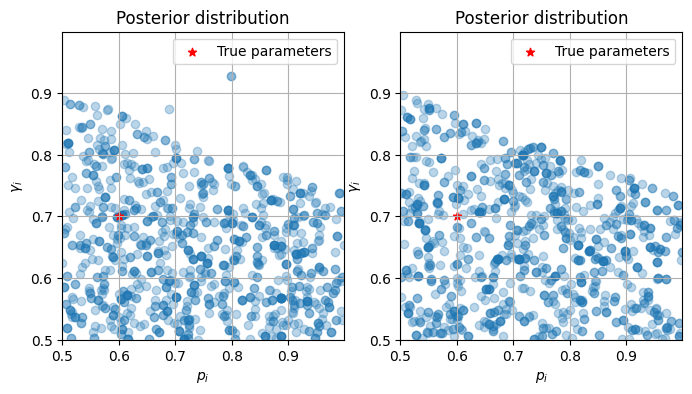

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plot_posterior_distribution(posterior_samples_1, true_params=true_params, ax=ax1)
plot_posterior_distribution(posterior_samples_2, true_params=true_params, ax=ax2)

In [ ]:
# Calculate standard deviation of the posterior samples
p_values_1, gamma_values_1 = zip(*(posterior_samples_1))
p_values_2, gamma_values_2 = zip(*(posterior_samples_2))

print(f"p_1: {np.std(p_values_1):.3f}, gamma_1: {np.std(gamma_values_1):.3f}")
print(f"p_2: {np.std(p_values_2):.3f}, gamma_2: {np.std(gamma_values_2):.3f}")

p_1: 0.038, gamma_1: 0.028
p_2: 0.040, gamma_2: 0.027
